This notebook maps electrode channels (the midpoint between two contacts) to hippocmapal surfaces. HippUnfold is run in space-nativepro, which is then registered to space-implant. Distances are calculated between chennel centroids and hippocampal surfaces, and all vertices within 5mm are given that channel bandpower values. 

For a more detailed explanation of code, see `notebooks/iEEG.ipynb`

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import nibabel as nib
import glob
import sys
sys.path.insert(1, '/export03/data/opt/hippunfold_toolbox/hippunfold_toolbox')
import plotting
import utils
import pandas as pd
import scipy.io
from scipy.signal import periodogram
import pygeodesic.geodesic as geodesic

In [25]:
micapipe_dir = '../sourcedata/Micapipe_MICs'
ieeg_dir = '/host/oncilla/local_raid/iEEG-BIDS' #(no ses)
ieeg_local = '../sourcedata/iEEG-local/'
hippunfold_dir = '/data/mica3/BIDS_MICs/derivatives/hippunfold_v1.3.0/hippunfold/'
subs = ['PX001', 'PX005', 'PX007', 'PX009', 
    'PX010', 'PX012', 'PX015', 'PX019', 'PX023', 
    'PX028', 'PX029', 'PX031', 'PX034', 'PX040', 
    'PX041', 'PX045', 'PX050', 'PX051', 'PX053',
    'PX065'] # omit PX004 because previous implant
ses = 'ses-01'
hemis = ['L','R']
labels = ['hipp']#,'dentate'] 
den='2mm'
ind = [range(419), range(419,483)] # index of how many dentate and hipp vertices are
shp = [419]#,64]
freq = 200 #Hz
bands = ['delta', 'theta', 'alpha', 'beta', 'gamma']
band_lims = np.array([[0.5,4], [4,8], [8,13], [13,30], [30,80]])
sampspace = np.arange(0.5,80,0.5)
dist_threshold = 5 #mm

In [26]:
pxx_all = np.zeros((len(sampspace),0))
cnames = np.zeros((3,0))
for s,sub in enumerate(subs):
    t = scipy.io.loadmat(f'/host/oncilla/local_raid/jessica/microstructure_iEEG/data/ieeg-mni/sub-{sub}_clean_ts.mat')
    f,pxx = scipy.signal.welch(t['dataclean'])
    for c in range(pxx.shape[0]):
        n1 = t['dataLabels'][0][c][0].split('-')[0].split(' ')[1]
        n2 = t['dataLabels'][0][c][0].split('-')[1].split(' ')[1]
        cnames = np.concatenate((cnames,np.array((sub,n1,n2)).reshape(-1,1)),axis=1)
        interpolator = scipy.interpolate.interp1d(f*freq,pxx[c,:]/np.sum(pxx[c,:]))
        pxx_all = np.concatenate((pxx_all,interpolator(sampspace).reshape(-1,1)),axis=1)

In [57]:
(y-err).shape

(159,)

(159, 2507)

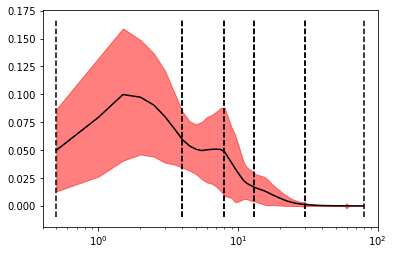

In [60]:
y = np.nanmean(pxx_all,axis=1)
err = np.nanstd(pxx_all,axis=1)
plt.plot(sampspace,y,'k-')
plt.fill_between(sampspace, y-err, y+err, alpha=0.5, color='r')
plt.vlines(band_lims.flatten(),plt.gca().get_ylim()[0],plt.gca().get_ylim()[1],colors='k',linestyles='--')
plt.xscale('log')
plt.xlim(0.4,100)

In [28]:
totbp = np.zeros((pxx_all.shape[1], len(bands)))
for b in range(len(bands)):
    for c in range(pxx_all.shape[1]):
        mask = np.logical_and(sampspace>band_lims[b,0], sampspace<band_lims[b,1])
        totbp[c,b] = np.trapz(pxx_all[mask,c],sampspace[mask])

/tmp/ipykernel_39130/706474401.py:16: UserWarning: Legend does not support <AxesSubplot:> instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend(handles=ax[1:])


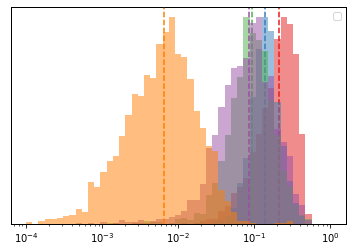

In [29]:
color_discrete = pl.cm.Set1(range(10))
l=['delta', 'theta', 'alpha', 'beta', 'gamma']
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.yaxis.set_visible(False)
ax = [ax]
n=0
for b in range(5):
    ax = ax + [ax[0].twinx()]
    dat = totbp[:,b]
    plt.axvline(x=np.nanmedian(dat), color=color_discrete[n], linestyle='dashed')
    ax[n+1].hist(dat,bins=np.logspace(np.log10(1e-4),np.log10(1), 50), linestyle=None, alpha=0.5, 
               color=color_discrete[b], label=l[b]);
    ax[n+1].yaxis.set_visible(False)
    n=n+1
plt.legend(handles=ax[1:])

In [30]:
# Register hippunfold surfaces to implant space
for s,sub in enumerate(subs):
    cmd1 = f'antsRegistrationSyNQuick.sh -d 3 -t r '\
    f'-m {micapipe_dir}/sub-{sub}/{ses}/anat/sub-{sub}_{ses}_space-nativepro_t1w.nii.gz '\
    f'-f {ieeg_dir}/sub-{sub}/anat/sub-{sub}_implanted.nii '\
    f'-o {ieeg_dir}/sub-{sub}/xfms/sub-{sub}_{ses}_space-nativepro-to-implanted_desc-rigid_'
    if not glob.glob(f'{ieeg_dir}/sub-{sub}/xfms/sub-{sub}_{ses}_space-nativepro-to-implanted_desc-rigid_0GenericAffine.mat'):
        !{cmd1}
    cmd2 = f'c3d_affine_tool '\
        f'-itk {ieeg_dir}/sub-{sub}/xfms/sub-{sub}_{ses}_space-nativepro-to-implanted_desc-rigid_0GenericAffine.mat '\
        f'-inv '\
        f'-o {ieeg_dir}/sub-{sub}/xfms/sub-{sub}_{ses}_space-nativepro-to-implanted_desc-rigid_0GenericAffine.txt'
    if not glob.glob(f'{ieeg_dir}/sub-{sub}/xfms/sub-{sub}_{ses}_space-nativepro-to-implanted_desc-rigid_0GenericAffine.txt'):
        !{cmd2}
    for h,hemi in enumerate(hemis):
        for l,label in enumerate(labels):    
            cmd3 = f'wb_command -surface-apply-affine '\
            f'{hippunfold_dir}/sub-{sub}/{ses}/surf/sub-{sub}_{ses}_hemi-{hemi}_space-T1w_den-{den}_label-{label}_midthickness.surf.gii '\
            f'{ieeg_dir}/sub-{sub}/xfms/sub-{sub}_{ses}_space-nativepro-to-implanted_desc-rigid_0GenericAffine.txt '\
            f'{ieeg_dir}/sub-{sub}/tmp/sub-{sub}_{ses}_hemi-{hemi}_space-implant_den-{den}_label-{label}_midthickness.surf.gii'
            if not glob.glob(f'{ieeg_dir}/sub-{sub}/tmp/sub-{sub}_{ses}_hemi-{hemi}_space-implant_den-{den}_label-{label}_midthickness.surf.gii'):
                !{cmd3}


In [31]:
def insensitive_glob(pattern):
    def either(c):
        return '[%s%s]' % (c.lower(), c.upper()) if c.isalpha() else c
    return glob.glob(''.join(map(either, pattern)))

In [32]:
change_table = {'filenames': ['sub-PX015/anat/electrode_LOTj.csv',
                                 'sub-PX028/anat/electrode_LHa.csv',
                                 'sub-PX028/anat/electrode_RFug.csv',
                                 'sub-PX031/anat/electrode_LA.csv',
                                 'sub-PX045/anat/electrode_LEC.csv',
                                 'sub-PX065/anat/electrode_RCP.csv',
                                 'sub-PX065/anat/electrode_RPt.csv'],
               'electrodenames': ['LTOJ',
                                 'LH',
                                 'RFus',
                                 'LIa',
                                 'LE',
                                 'RPC',
                                 'RTp']}

In [33]:
hipp_dat = np.ones([sum(shp),2,5,pxx_all.shape[1]])*np.nan
hipp_dat_perio = np.ones([sum(shp),2,len(sampspace),pxx_all.shape[1]])*np.nan
missing_electrodes = []
for h,hemi in enumerate(hemis):
    for c in range(pxx_all.shape[1]):
        sub = cnames[0,c]
        surf = nib.load(f'{ieeg_dir}/sub-{sub}/tmp/sub-{sub}_{ses}_hemi-{hemi}_space-implant_den-{den}_label-{label}_midthickness.surf.gii')
        vertices = surf.get_arrays_from_intent('NIFTI_INTENT_POINTSET')[0].data
        ename = ''.join([i for i in cnames[1,c] if not i.isdigit()])
        electrode = insensitive_glob(f'{ieeg_dir}/sub-{sub}/anat/electrode_{ename}.csv')
        ## this block sucks but we need to rename some electrodes
        if f'sub-{sub}/anat/electrode_{ename}.csv' in change_table['filenames']:
            i = change_table['filenames'].index(f'sub-{sub}/anat/electrode_{ename}.csv')
            ename = change_table['electrodenames'][i]
            enum = ''.join([i for i in cnames[1,c] if i.isdigit()])
            cnames[1,c] = ename+enum
            enum = ''.join([i for i in cnames[2,c] if i.isdigit()])
            cnames[2,c] = ename+enum
            electrode = insensitive_glob(f'{ieeg_dir}/sub-{sub}/anat/electrode_{ename}.csv')
        ## end sucky block
        if electrode:
            try:
                file = open(electrode[0],'r')
                for line in file.readlines():
                    if f'[contact],{cnames[1,c]}' in line:
                        xyz1 = line.split(',')[3:6]
                    elif f'[contact],{cnames[2,c]}' in line:
                        xyz2 = line.split(',')[3:6]
                file.close()
                xyz = (np.asarray(xyz1, dtype=float)+np.asarray(xyz2, dtype=float))/2
                for v in range(len(vertices)):
                    dist = np.linalg.norm(xyz-vertices[v,:])
                    if dist <= dist_threshold:
                        hipp_dat[v,h,:,c] = totbp[c,:]
                        hipp_dat_perio[v,h,:,c] = pxx_all[:,c]
            except:
                print(f'sub-{sub}/anat/electrode_{ename}.csv contact {cnames[1,c]} and {cnames[2,c]} not found at {c}')
        else:
            missing_electrodes.append(f'sub-{sub}/anat/electrode_{ename}.csv')
set(missing_electrodes)

set()

In [34]:
print('number of L hemis: ' + str(len(np.where(np.any(~np.isnan(hipp_dat[:,0,0,:]),axis=0))[0])))
print('number of R hemis: ' + str(len(np.where(np.any(~np.isnan(hipp_dat[:,1,0,:]),axis=0))[0])))

number of L hemis: 7
number of R hemis: 37


/export03/data/opt/venv/lib/python3.8/site-packages/brainspace/plotting/base.py:287: UserWarning: Interactive mode requires 'panel'. Setting 'interactive=False'
  warnings.warn("Interactive mode requires 'panel'. "


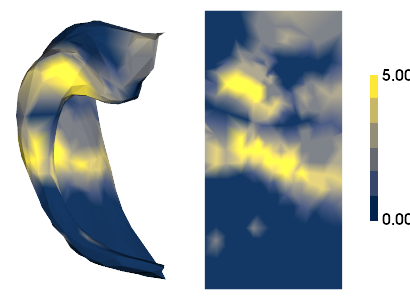

In [35]:
hipp_dat_count = np.sum(~np.isnan(hipp_dat),axis=(1,3))[:,0]
plotting.surfplot_canonical_foldunfold(hipp_dat_count, den='2mm', hemis=['L'], labels=labels, unfoldAPrescale=True, tighten_cwindow=True, cmap='cividis', share='row', color_bar='right', embed_nb=True)

(0.4, 100)

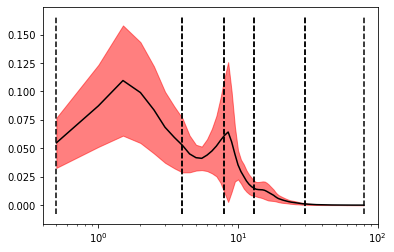

In [61]:
y = np.nanmean(hipp_dat_perio,axis=(0,1,3))
err = np.nanstd(hipp_dat_perio,axis=(0,1,3))
plt.plot(sampspace,y,'k-')
plt.fill_between(sampspace, y-err, y+err, alpha=0.5, color='r')
plt.vlines(band_lims.flatten(),plt.gca().get_ylim()[0],plt.gca().get_ylim()[1],colors='k',linestyles='--')
plt.xscale('log')
plt.xlim(0.4,100)

/tmp/ipykernel_39130/1351624638.py:16: UserWarning: Legend does not support <AxesSubplot:> instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend(handles=ax[1:])


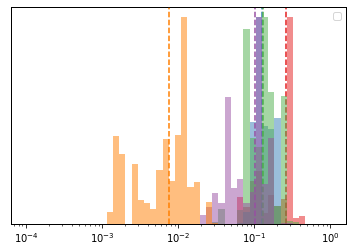

In [37]:
color_discrete = plt.cm.Set1(range(10))
l=['delta', 'theta', 'alpha', 'beta', 'gamma']
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.yaxis.set_visible(False)
ax = [ax]
n=0
for b in range(5):
    ax = ax + [ax[0].twinx()]
    dat = hipp_dat[:,:,b,:].flatten()
    plt.axvline(x=np.nanmedian(dat), color=color_discrete[n], linestyle='dashed')
    ax[n+1].hist(dat,bins=np.logspace(np.log10(1e-4),np.log10(1), 50), linestyle=None, alpha=0.5, 
               color=color_discrete[b], label=l[b]);
    ax[n+1].yaxis.set_visible(False)
    n=n+1
plt.legend(handles=ax[1:])

In [38]:
import importlib
importlib.reload(utils)
resorcesdir = '/export03/data/opt/hippunfold_toolbox/resources'
gii = nib.load(f'{resorcesdir}/canonical_surfs/tpl-avg_space-canonical_den-{den}_label-hipp_midthickness.surf.gii')
v = gii.get_arrays_from_intent('NIFTI_INTENT_POINTSET')[0].data
f = gii.get_arrays_from_intent('NIFTI_INTENT_TRIANGLE')[0].data
gii = nib.load(f'{resorcesdir}/canonical_surfs/tpl-avg_space-canonical_den-{den}_label-dentate_midthickness.surf.gii')
vdg = gii.get_arrays_from_intent('NIFTI_INTENT_POINTSET')[0].data
fdg = gii.get_arrays_from_intent('NIFTI_INTENT_TRIANGLE')[0].data
F = [f, fdg]
V = [v, vdg]

In [39]:
# cominbing BP across channels and vertices for visualization
# here, we exctrapoalte the data from any channel across the entire hippocampus, and then average across all channels. However, the average across channels is weighted by distance to the actual channel contact. 

weights_hipp_dat = np.ones((hipp_dat.shape[0],2,hipp_dat.shape[3]))*np.nan
interp_hipp_dat = np.zeros([hipp_dat.shape[0],5])
interp_hipp_perio_dat = np.zeros([hipp_dat.shape[0],len(pxx_all)])

for h,hemis in enumerate(hemis):
    for c in range(hipp_dat.shape[3]):
        for l,label in enumerate(labels):
            mask = ~np.isnan(hipp_dat[ind[l],h,0,c])
            if np.any(mask):
                geoalg = geodesic.PyGeodesicAlgorithmExact(V[l], F[l])
                sd,_ = geoalg.geodesicDistances(np.where(mask)[0], None)
                weights_hipp_dat[ind[l],h,c] = 1 - (sd/np.max(sd))
totweights = np.nansum(weights_hipp_dat, axis=(1,2))
for v in range(weights_hipp_dat.shape[0]):
    for h,hemis in enumerate(hemis):
        for c in range(hipp_dat.shape[3]):
            w = weights_hipp_dat[v,h,c] / totweights[v]
            if w>0:
                interp_hipp_dat[v,:] += np.nanmean(hipp_dat[:,h,:,c],axis=0) * w
                interp_hipp_perio_dat[v,:] += np.nanmean(hipp_dat_perio[:,h,:,c],axis=0) * w

/export03/data/opt/venv/lib/python3.8/site-packages/brainspace/plotting/base.py:287: UserWarning: Interactive mode requires 'panel'. Setting 'interactive=False'
  warnings.warn("Interactive mode requires 'panel'. "


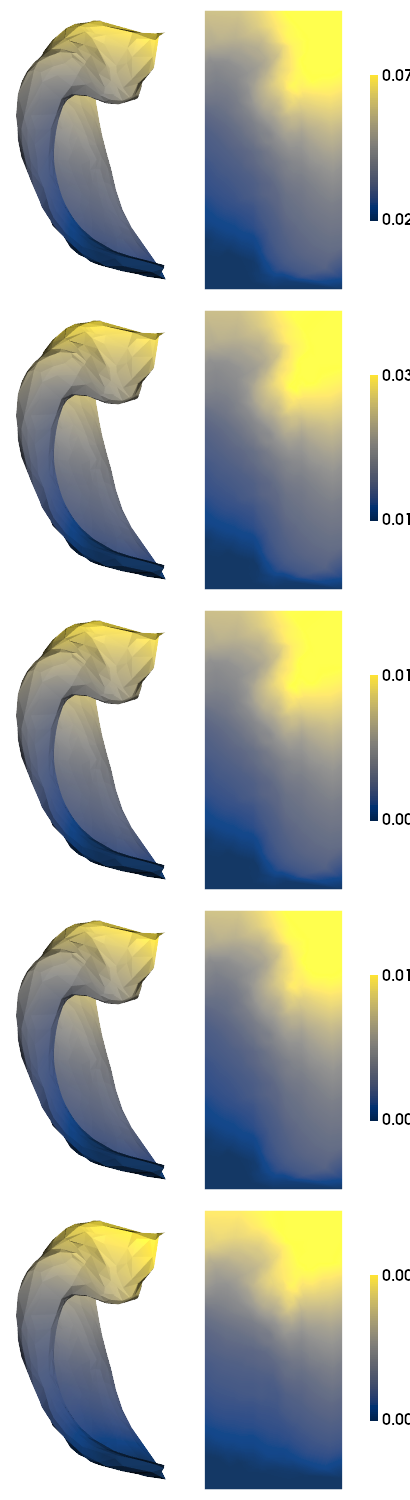

In [40]:
plotting.surfplot_canonical_foldunfold(interp_hipp_dat, den=den, hemis=['L'], labels=labels, unfoldAPrescale=True, tighten_cwindow=True, cmap='cividis', share='row', color_bar='right', embed_nb=True)

## example of how data gets extrapolated along a geodesic distance

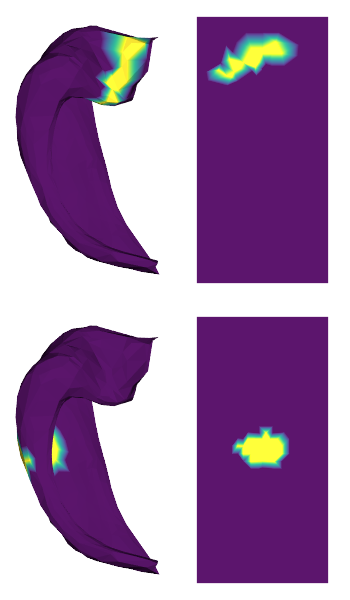

In [41]:
import copy
hd = copy.deepcopy(hipp_dat)
wd = copy.deepcopy(weights_hipp_dat)
hd[np.isnan(hd)] = 0
wd[np.isnan(wd)] = 0

h=1
c=[1201,1635]
plotting.surfplot_canonical_foldunfold(hd[:,h,b,c], hemis=['L'], labels=labels, den=den, embed_nb=True)

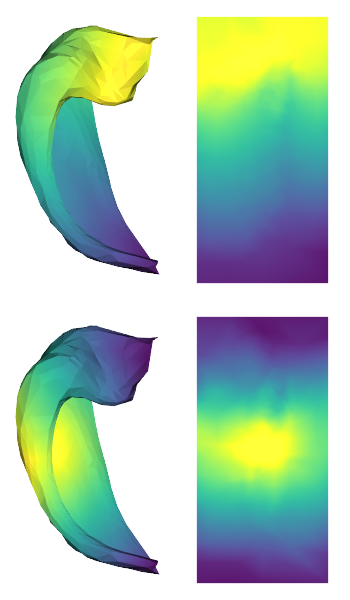

In [42]:
plotting.surfplot_canonical_foldunfold(wd[:,h,c], hemis=['L'], labels=labels, den=den, embed_nb=True)

## Brainspace gradients

In [43]:
from brainspace.gradient import GradientMaps
# gradient decomposition
bpgm = GradientMaps(n_components=5, kernel='normalized_angle')
bpgm.fit(interp_hipp_perio_dat)

GradientMaps(kernel='normalized_angle', n_components=5)

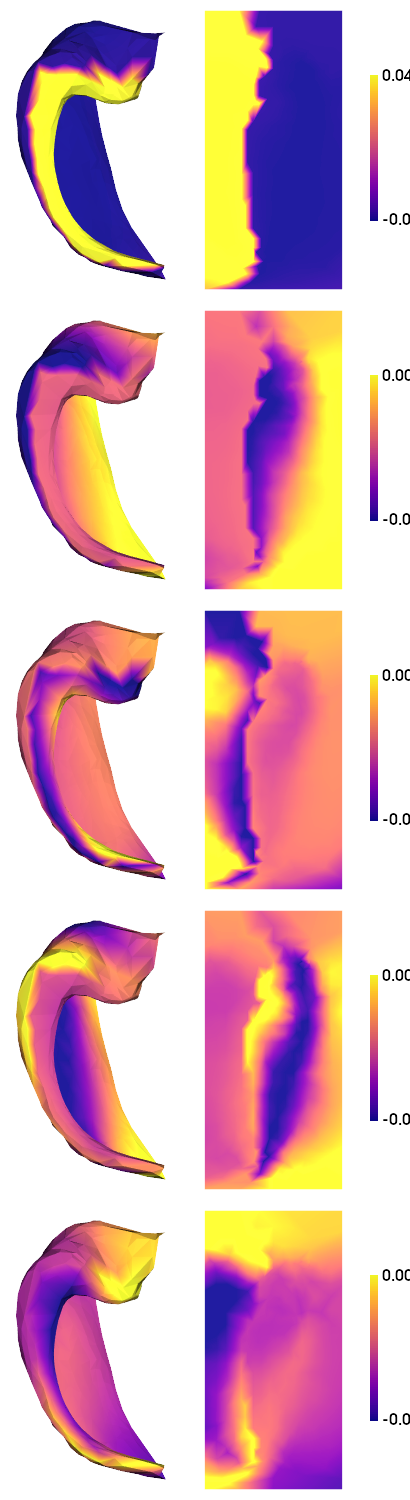

In [44]:
plotting.surfplot_canonical_foldunfold(bpgm.gradients_, den=den, hemis=['L'], labels=labels, unfoldAPrescale=True, tighten_cwindow=True, cmap='plasma', share='row', color_bar='right', embed_nb=True)

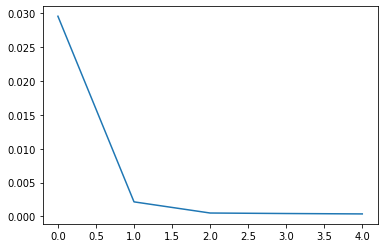

In [45]:
plt.plot(bpgm.lambdas_)

(0.4, 100)

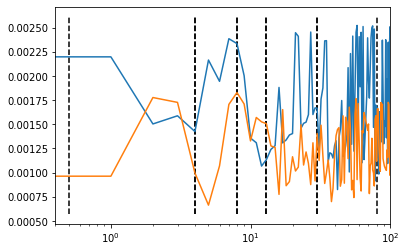

In [46]:
# compare top to bottom

nverts = np.sum(shp)
nvertsplit = int(nverts*.25)

bot = np.argpartition(bpgm.gradients_[:,0],nvertsplit)[:nvertsplit]
top = np.argpartition(bpgm.gradients_[:,0],-nvertsplit)[-nvertsplit:]

plt.plot(np.mean(interp_hipp_perio_dat[bot,:],axis=1))
plt.plot(np.mean(interp_hipp_perio_dat[top,:],axis=1))
#plt.yscale('log')
plt.xscale('log')
plt.vlines(band_lims.flatten(),plt.gca().get_ylim()[0],plt.gca().get_ylim()[1],colors='k',linestyles='--')
plt.xlim(0.4,100)